# Zero Shot Evaluation Tutorial

## Step 1: Setup

In [1]:
# Set up the environment.
from embedding_extractors import download_scgpt_model, download_geneformer_model, download_genept_data

download_scgpt_model()
download_geneformer_model()
download_genept_data()

✅ File downloaded to: embedding_extractors/models/scGPT/model/
✅ File downloaded to: embedding_extractors/models/geneformer/model/gf-20L-95M-i4096
✅ File downloaded to: embedding_extractors/models/genePT/model/


## Step 2: Extract cell embeddings

#### a) Pre process raw expression metrics

In [14]:
# Pre-process filtered cell expression metrics (no further processes are needed).

# Set up configurations for the pre-processor, example configs can be found in `embedding_extractors/config.py`.
preprocessor_configs = dict(
    # The directory to store raw data.
    # Note: Currently only accept Anndata files with gene names in `vars`. The supported gene naming system includes
    # "gene_symbol", "ensembl_id", "entrez_id", "refseq_id".
    raw_data_directory='pmbc_12k/',  # pbmc 12k data can be downloaded from scvi-tools Python library
    # The directory to store preprocessed data.
    preprocessed_data_directory='pbmc/pre_processed',
    # The column name of gene ID in `adata.var`. If the gene ID is the index, input `index`.
    gene_id_col_name='index',
    # The type of gene naming system in the gene ID: {"gene_symbol", "ensembl_id", "entrez_id", "refseq_id"}.
    gene_id_type='ensembl_id',
    # The input file format. Currently only Anndata is supported.
    file_format='h5ad',
    # Whether to keep batch key. If true, the input file directory name will be used as the batch key and stored under
    # `adata.obs.batch_key`.
    keep_batch_key=True,
    # Subsample ratio of raw gene expressions, range (0, 1]. If the value is 1, all gene expressions will be included.
    gene_expression_subsample_ratio=1,
    # Map of cell attribute labels in `obs` to keep. Key is the name in original file, value is the name in
    # pre-processed file. If none, use empty map {}.
    custom_cell_attr_names={'str_labels': 'cell_type'},
)

In [15]:
from embedding_extractors import pre_processor

processor = pre_processor.PreProcessor()
processor.pre_process(preprocessor_configs)

Pre-processing pmbc_12k\pbmc_12k.h5ad
Pre-process completed: pbmc/pre_processed\pbmc_12k.h5ad. Shape:
AnnData object with n_obs × n_vars = 11990 × 3346
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type', 'batch_key', 'original_n_counts'
    var: 'key_0', 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'ensembl_id', 'gene_symbol', 'entrez_id', 'refseq_id'
    uns: 'cell_types'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'
Successfully pre-processed 1 out of 1 file(s).


#### b) Tokenize and extract cell embeddings

In [19]:
# Generate cell embeddings with Geneformer.
"""
Geneformer configs
"""
geneformer_configs = dict(
    # The directory to store preprocessed data.
    preprocessed_data_directory='pbmc/pre_processed',
    # The output tokenized file directory.
    tokenized_file_directory="pbmc/tokenized",
    # The output tokenized filename prefix.
    tokenized_file_prefix='geneformer',
    # The output embedding file directory.
    embedding_output_directory="pbmc",
    # The output embedding file name.
    embedding_output_filename="geneformer_cell_embeddings",
    # List of cell attribute labels to keep, i.e. `cell_type` and `batch_key`. If none, use empty list [].
    custom_cell_attr_names=['cell_type', 'batch_key'],
)

from embedding_extractors import EmbeddingExtractor

emb_extractor = EmbeddingExtractor("Geneformer", output_file_type='h5ad', configs=geneformer_configs)
emb_extractor.tokenize()
emb_extractor.extract_embeddings()

Tokenizing pbmc\pre_processed\pbmc_12k.h5ad


100%|██████████| 24/24 [00:00<00:00, 51.50it/s]


pbmc\pre_processed\pbmc_12k.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Tokenizing pbmc\pre_processed\pbmc_59k.h5ad


100%|██████████| 117/117 [00:22<00:00,  5.12it/s]


pbmc\pre_processed\pbmc_59k.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Tokenizing pbmc\pre_processed\pbmc_67k.h5ad


100%|██████████| 131/131 [00:09<00:00, 14.36it/s]


pbmc\pre_processed\pbmc_67k.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


Saving the dataset (2/2 shards): 100%|██████████| 138481/138481 [00:00<00:00, 668459.81 examples/s]


Tokenization completed for Geneformer.
Extracting Geneformer embeddings


100%|██████████| 13849/13849 [1:15:04<00:00,  3.07it/s]


Output embedding in pbmc\geneformer_cell_embeddings.h5ad



In [18]:
# Generate cell embeddings with scGPT.
"""
scGPT configs
"""
scgpt_configs = dict(
    # The directory to store preprocessed data.
    preprocessed_data_directory='pbmc/pre_processed',
    # The output embedding file directory.
    embedding_output_directory="pbmc",
    # The output embedding file name.
    embedding_output_filename="scgpt_cell_embeddings",
    # List of cell attribute labels to keep, i.e. `cell_type` and `batch_key`. If none, use empty list [].
    custom_cell_attr_names=['cell_type', 'batch_key'],
)

from embedding_extractors import EmbeddingExtractor

emb_extractor = EmbeddingExtractor("scGPT", output_file_type='h5ad', configs=scgpt_configs)
emb_extractor.tokenize()
emb_extractor.extract_embeddings()

Extracting scGPT embeddings
Embedding pbmc/pre_processed\pbmc_12k.h5ad


Embedding cells: 100%|██████████| 188/188 [00:23<00:00,  8.09it/s]


Embedding pbmc/pre_processed\pbmc_59k.h5ad


Embedding cells: 100%|██████████| 930/930 [02:21<00:00,  6.57it/s]


Embedding pbmc/pre_processed\pbmc_67k.h5ad


Embedding cells: 100%|██████████| 1047/1047 [02:41<00:00,  6.47it/s]


Output embedding in pbmc\scgpt_cell_embeddings.h5ad


In [17]:
# Generate cell embeddings with GenePT-w.

"""
genePT configs
"""
genept_configs = dict(
    # The directory to store preprocessed data.
    preprocessed_data_directory='pbmc/pre_processed',
    # The output embedding file directory for genePT-w.
    genept_w_embedding_output_directory="pbmc",
    # The output embedding file name.
    embedding_output_filename="genept_w_cell_embeddings",
    # List of cell attribute labels to keep, i.e. `cell_type` and `batch_key`. If none, use empty list [].
    custom_cell_attr_names=['cell_type', 'batch_key'],
)

from embedding_extractors import EmbeddingExtractor

emb_extractor = EmbeddingExtractor("genePT-w", output_file_type='h5ad', configs=genept_configs)
emb_extractor.tokenize()
emb_extractor.extract_embeddings()

Extracting genePT-W embeddings
Embedding pbmc/pre_processed\pbmc_12k.h5ad
Unable to match 24 out of 3346 genes in pbmc/pre_processed\pbmc_12k.h5ad
Embedding pbmc/pre_processed\pbmc_59k.h5ad
Unable to match 6313 out of 23948 genes in pbmc/pre_processed\pbmc_59k.h5ad
Embedding pbmc/pre_processed\pbmc_67k.h5ad
Unable to match 15196 out of 36263 genes in pbmc/pre_processed\pbmc_67k.h5ad
Output embedding in pbmc\genept_w_cell_embeddings.h5ad



In [ ]:
# Generate cell embeddings with GenePT-s.

"""
genePT configs
"""
genept_configs = dict(
    # The directory to store preprocessed data.
    preprocessed_data_directory='pbmc/pre_processed',
    # The output embedding file directory for genePT-s.
    genept_s_embedding_output_directory="pbmc",
    # The used openai model name.
    genept_s_openai_model_name='text-embedding-ada-002',
    # The output embedding file name.
    embedding_output_filename="genept_s_cell_embeddings",
    # OpenAI api key.
    openai_api_key='',  # remember to set your open AI API key!
    openai_api_max_threads=10,
    # List of cell attribute labels to keep, i.e. `cell_type` and `batch_key`. If none, use empty list [].
    custom_cell_attr_names=['cell_type', 'batch_key'],
)
from embedding_extractors import EmbeddingExtractor

emb_extractor = EmbeddingExtractor("genePT-s", output_file_type='h5ad', configs=genept_configs)
emb_extractor.tokenize()
emb_extractor.extract_embeddings()

D:\Beaver\code\scRNAseq-Embedding-Benchmark\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting genePT-s embeddings
Embedding pbmc/pre_processed\pbmc_12k.h5ad
Processed 0 out of 11990 cells...
Processed 1000 out of 11990 cells...
Processed 2000 out of 11990 cells...
Processed 3000 out of 11990 cells...
Processed 4000 out of 11990 cells...
Processed 5000 out of 11990 cells...
Processed 6000 out of 11990 cells...
Processed 7000 out of 11990 cells...
Processed 8000 out of 11990 cells...
Processed 9000 out of 11990 cells...
Processed 10000 out of 11990 cells...
Processed 11000 out of 11990 cells...
Failed to fetch embeddings from OpenAi. Attempt 1: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
Failed to fetch embeddings from OpenAi. Attempt 1: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
Failed to fetch embeddings from OpenAi. Attempt 1: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
Embedd

## Step 3: Zero-shot Evaluation

#### a) Cell type labeling

Evaluating genePT-s model: 103526 out of 138481 cell embeddings after filtering.
	Cell embeddings shape: (103526, 1536)
Evaluating scGPT model: 103526 out of 138481 cell embeddings after filtering.
	Cell embeddings shape: (103526, 512)
Evaluating Geneformer model: 103526 out of 138481 cell embeddings after filtering.
	Cell embeddings shape: (103526, 896)
Evaluating genePT-w model: 103526 out of 138481 cell embeddings after filtering.
	Cell embeddings shape: (103526, 1536)


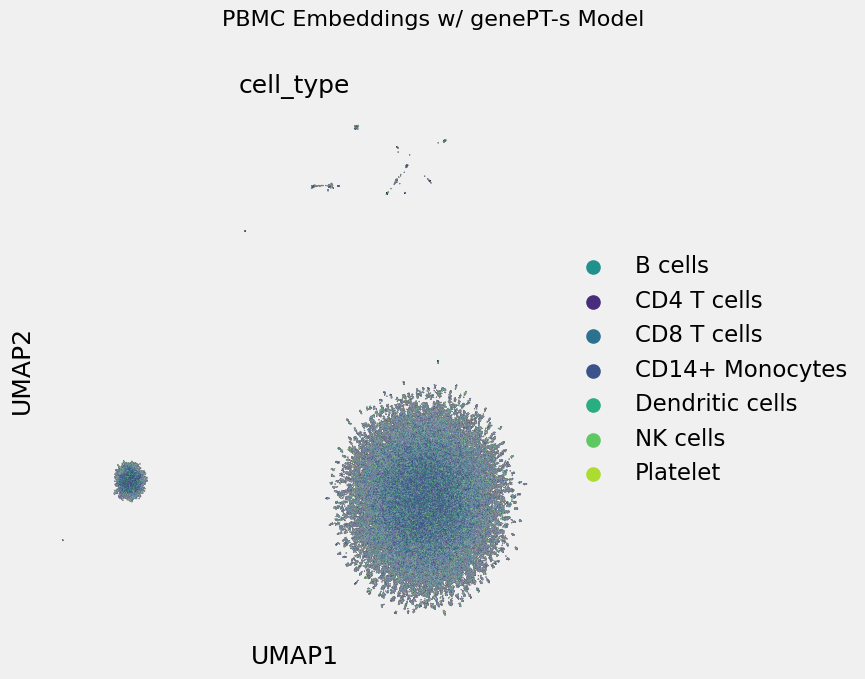

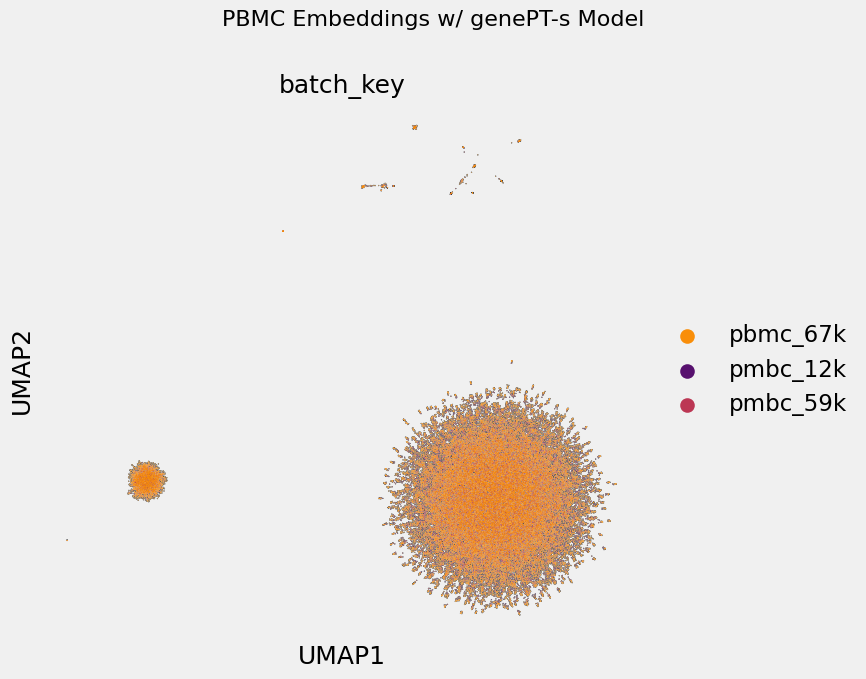

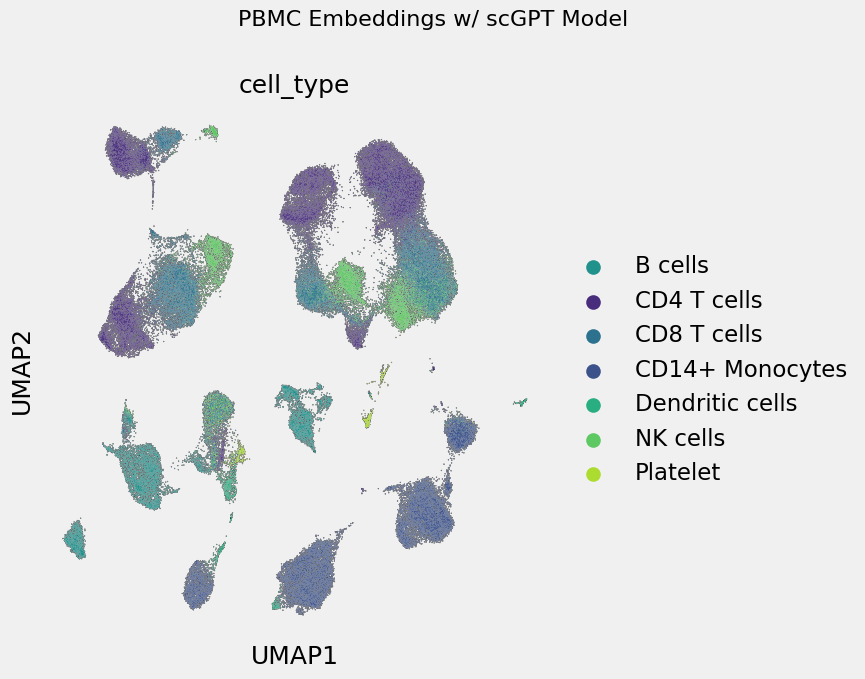

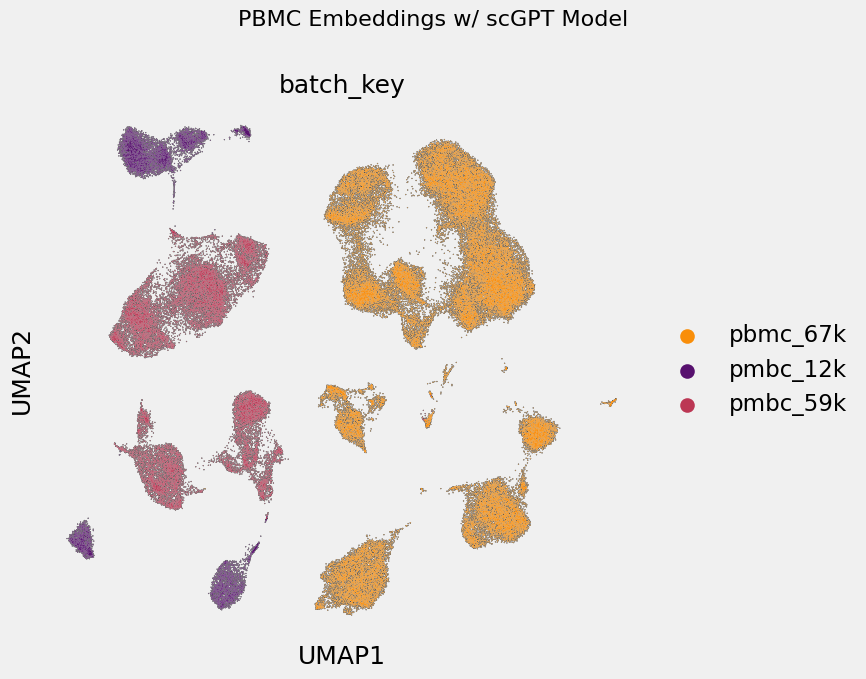

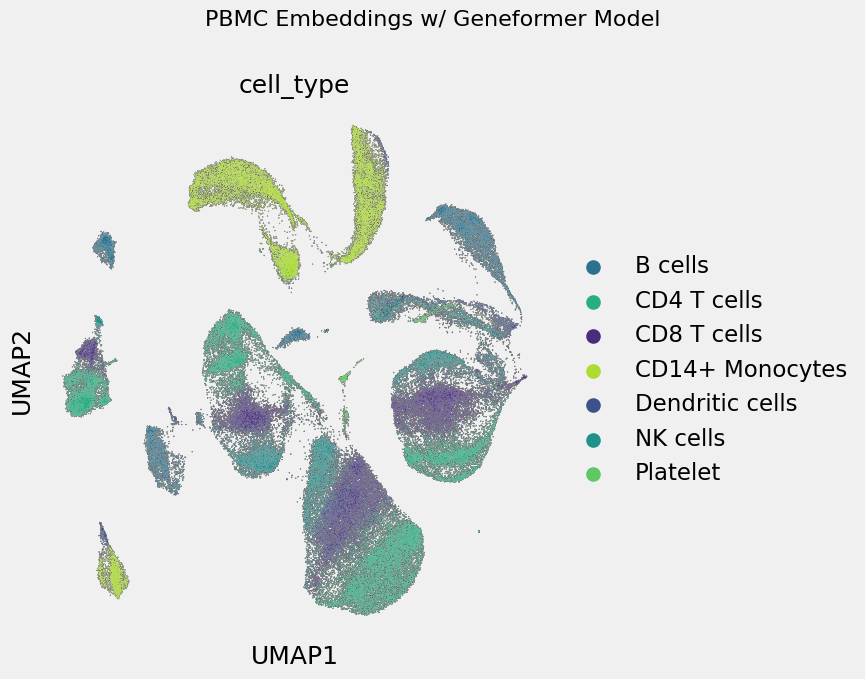

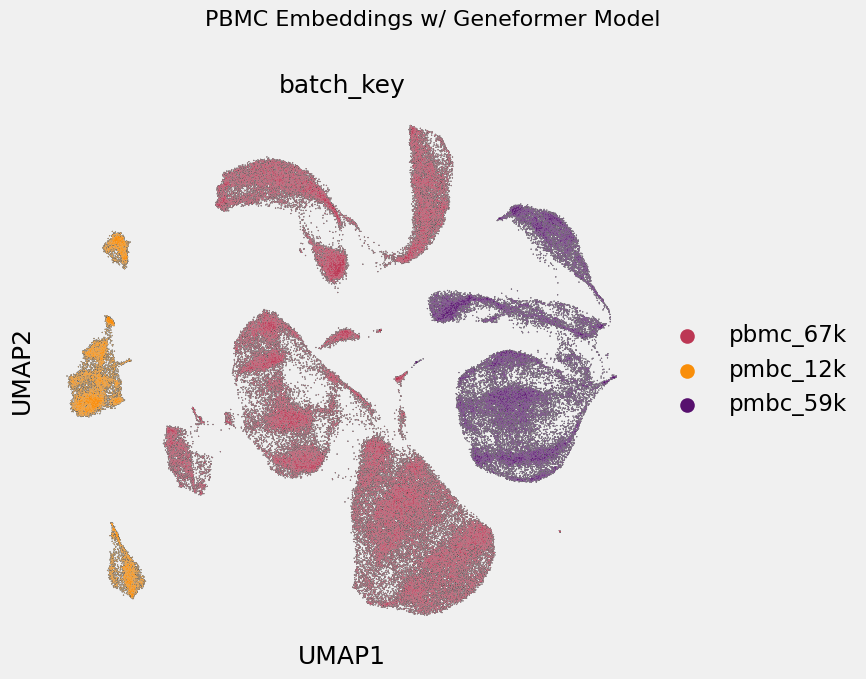

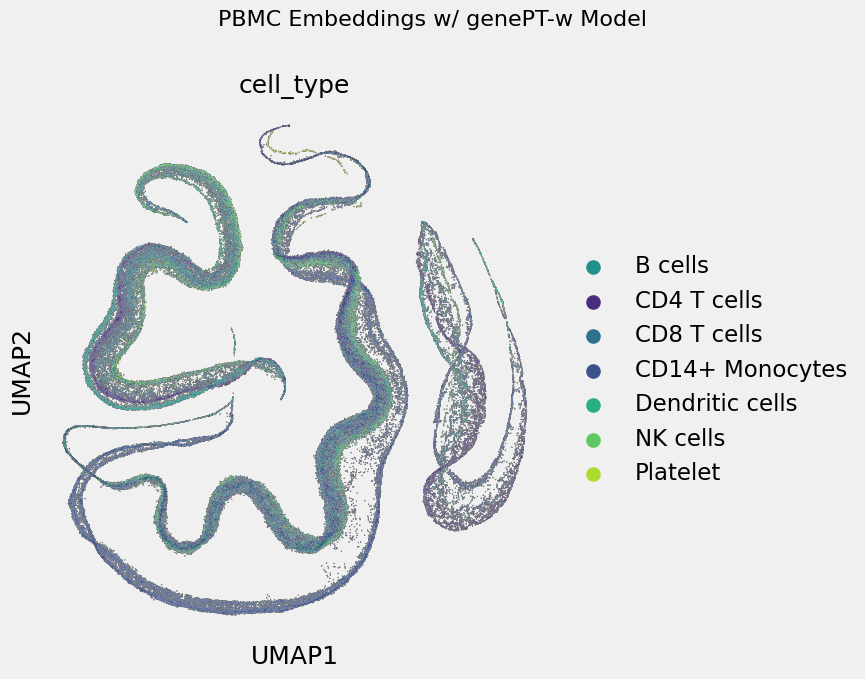

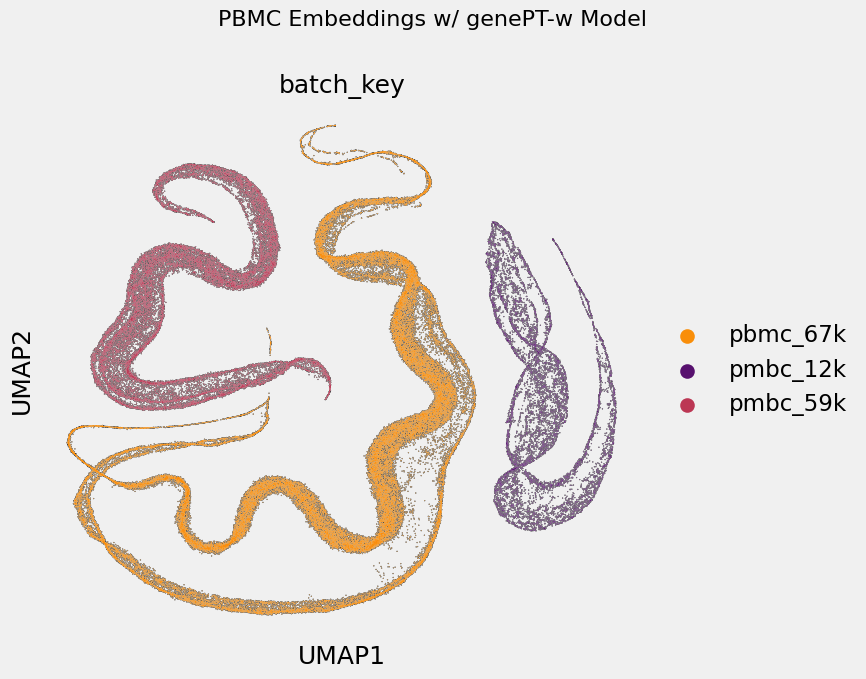

In [1]:
from eval import ZeroShotCellEmbeddingsEval
import warnings

warnings.filterwarnings("ignore")

# Calculates cluster metrics for cell embeddings.
for model in {"scGPT", "genePT-w", "genePT-s", "Geneformer"}:
    eval = ZeroShotCellEmbeddingsEval(model_name=model,
                                      embedding_file_path=f'pbmc/{model.lower().replace("-", "_")}_cell_embeddings.h5ad',
                                      output_dir=f'pbmc/eval/',
                                      embedding_key=f"X_{model}",
                                      label_key=['cell_type'],
                                      label_key_filter=[['B cells', 'Dendritic cells', 'CD4 T cells', 'CD8 T cells',
                                                         'CD14+ Monocytes', 'Platelet', 'NK cells']],
                                      batch_key='batch_key')
    eval.visualize(return_fig=False, plot_title=f"PBMC Embeddings w/ {model} Model",
                   plot_type='scanpy',
                   n_cells=-1)

In [1]:
from eval import ZeroShotCellEmbeddingsEval
import warnings

warnings.filterwarnings("ignore")

# Calculates cluster metrics for cell embeddings.
for model in {"scGPT", "genePT-w", "genePT-s", "Geneformer"}:
    eval = ZeroShotCellEmbeddingsEval(model_name=model,
                                      embedding_file_path=f'pbmc/{model.lower().replace("-", "_")}_cell_embeddings.h5ad',
                                      output_dir=f'pbmc/eval/',
                                      embedding_key=f"X_{model}",
                                      label_key=['cell_type'],
                                      label_key_filter=[['B cells', 'Dendritic cells', 'CD4 T cells', 'CD8 T cells',
                                                         'CD14+ Monocytes', 'Platelet', 'NK cells']],
                                      batch_key='batch_key')
    print(eval.evaluate(n_cells=-1))
    print('\n')

Evaluating Geneformer model: 103526 out of 138481 cell embeddings after filtering.
              metric      label     value
0  NMI_cluster/label  cell_type  0.542716
1  ARI_cluster/label  cell_type  0.302242
2          ASW_label  cell_type  0.534943
3         graph_conn  cell_type  0.815588
4          ASW_batch  cell_type  0.649214
5    ASW_label/batch  cell_type  0.591479
6          PCR_batch  cell_type  0.423330
7            avg_bio  cell_type  0.459967


Evaluating scGPT model: 103526 out of 138481 cell embeddings after filtering.
              metric      label     value
0  NMI_cluster/label  cell_type  0.570870
1  ARI_cluster/label  cell_type  0.313911
2          ASW_label  cell_type  0.561647
3         graph_conn  cell_type  0.964809
4          ASW_batch  cell_type  0.578816
5    ASW_label/batch  cell_type  0.726299
6          PCR_batch  cell_type  0.209035
7            avg_bio  cell_type  0.482142


Evaluating genePT-w model: 103526 out of 138481 cell embeddings after filtering

#### b) Robustness evaluation

Evaluating scGPT model: 103526 out of 138481 cell embeddings after filtering.
	Cell embeddings shape: (103526, 512)
Evaluating Geneformer model: 103526 out of 138481 cell embeddings after filtering.
	Cell embeddings shape: (103526, 896)
Evaluating genePT-w model: 103526 out of 138481 cell embeddings after filtering.
	Cell embeddings shape: (103526, 1536)


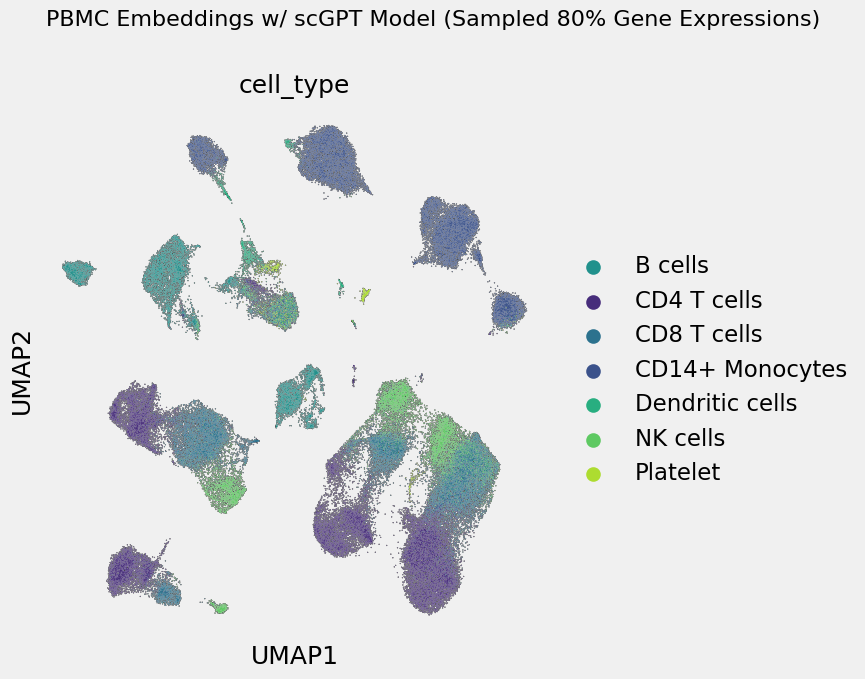

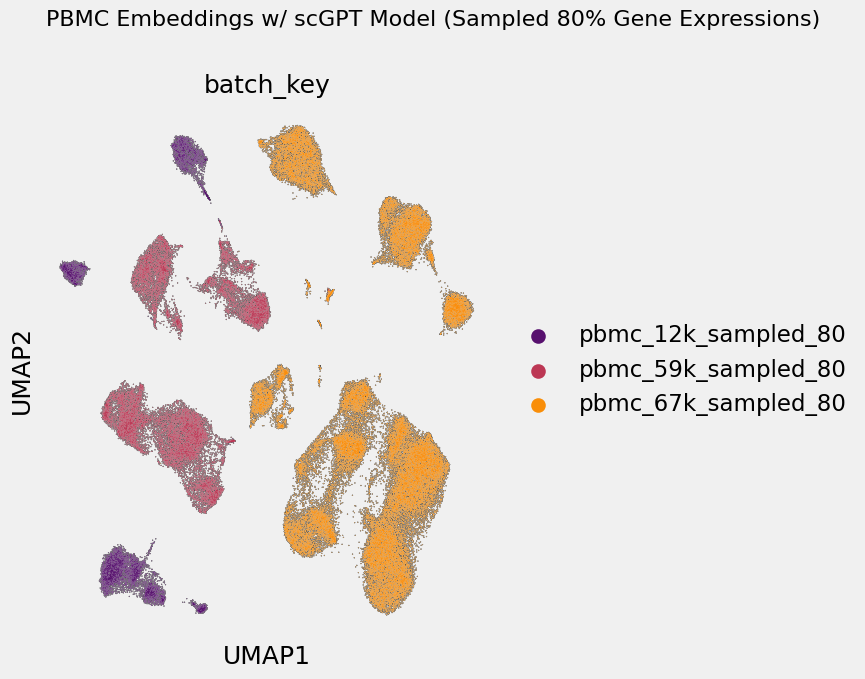

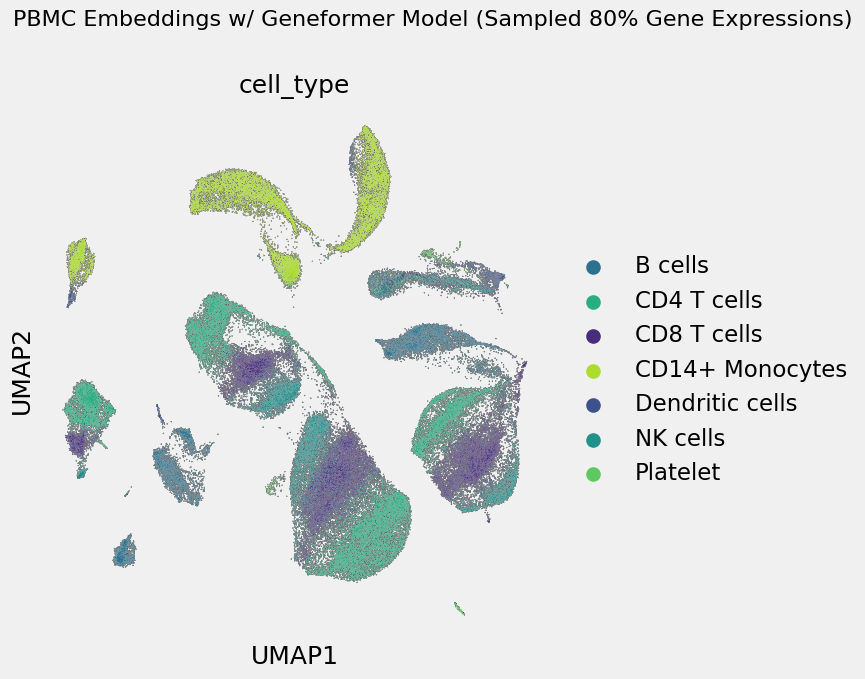

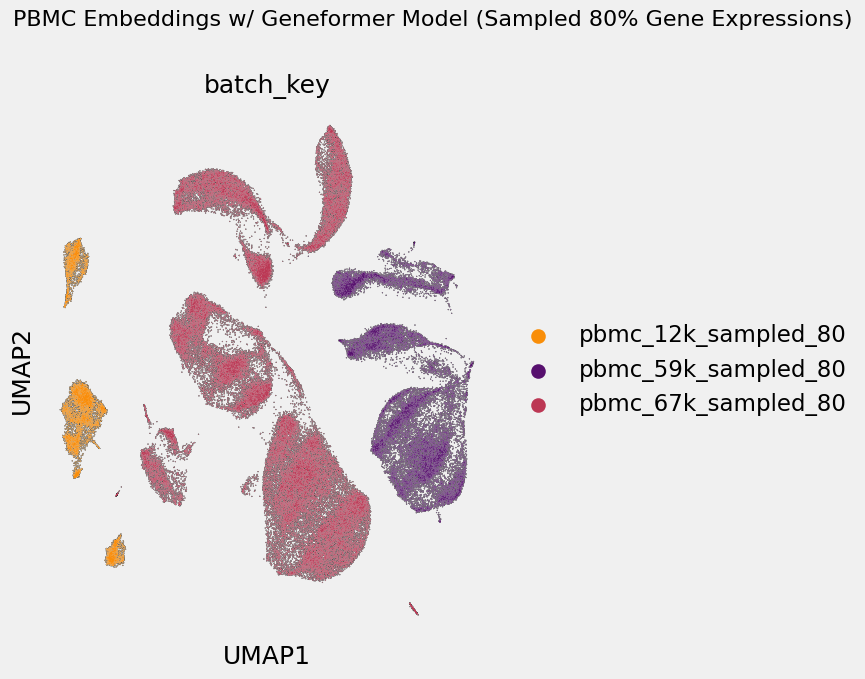

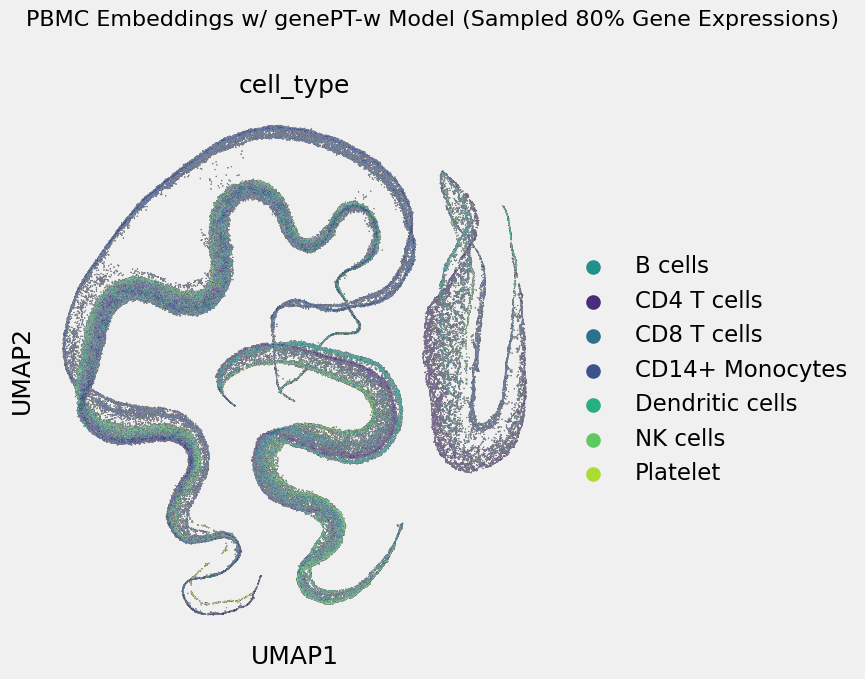

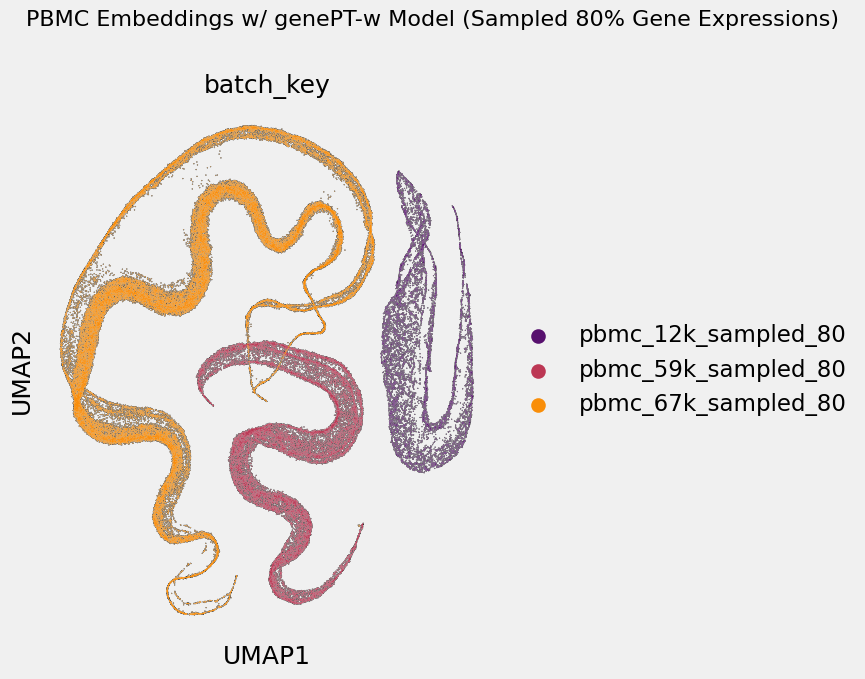

In [1]:
from eval import ZeroShotCellEmbeddingsEval
import warnings

warnings.filterwarnings("ignore")

# Evaluate cell labeling capability with 80% sampled gene expression.
for model in {"scGPT", "genePT-w", "Geneformer"}:
    eval = ZeroShotCellEmbeddingsEval(model_name=model,
                                      embedding_file_path=f'pbmc_sampled_80/sampled_{model.lower().replace("-", "_")}_cell_embeddings.h5ad',
                                      output_dir=f'pbmc_sampled_80/eval/',
                                      embedding_key=f"X_{model}",
                                      label_key=['cell_type'],
                                      label_key_filter=[['B cells', 'Dendritic cells', 'CD4 T cells', 'CD8 T cells',
                                                         'CD14+ Monocytes', 'Platelet', 'NK cells']],
                                      batch_key='batch_key')
    eval.visualize(return_fig=False, plot_title=f"PBMC Embeddings w/ {model} Model (Sampled 80% Gene Expressions)",
                   plot_type='scanpy',
                   n_cells=-1)

In [2]:
from eval import ZeroShotCellEmbeddingsEval
import warnings

warnings.filterwarnings("ignore")

# Evaluate cell labeling capability with 80% sampled gene expression.
for model in {"scGPT", "genePT-w", "Geneformer"}:
    eval = ZeroShotCellEmbeddingsEval(model_name=model,
                                      embedding_file_path=f'pbmc_sampled_80/sampled_{model.lower().replace("-", "_")}_cell_embeddings.h5ad',
                                      output_dir=f'pbmc_sampled_80/eval/',
                                      embedding_key=f"X_{model}",
                                      label_key=['cell_type'],
                                      label_key_filter=[['B cells', 'Dendritic cells', 'CD4 T cells', 'CD8 T cells',
                                                         'CD14+ Monocytes', 'Platelet', 'NK cells']],
                                      batch_key='batch_key')
    print(eval.evaluate(n_cells=7500))
    print('\n')

Evaluating scGPT model: 103526 out of 138481 cell embeddings after filtering.
adata_ has 103526 cells. Taking a subset of 7500 cells.
              metric      label     value
0  NMI_cluster/label  cell_type  0.563412
1  ARI_cluster/label  cell_type  0.308262
2          ASW_label  cell_type  0.561519
3         graph_conn  cell_type  0.887550
4          ASW_batch  cell_type  0.578507
5    ASW_label/batch  cell_type  0.730657
6          PCR_batch  cell_type  0.210987
7            avg_bio  cell_type  0.477731


Evaluating Geneformer model: 103526 out of 138481 cell embeddings after filtering.
adata_ has 103526 cells. Taking a subset of 7500 cells.
              metric      label     value
0  NMI_cluster/label  cell_type  0.514193
1  ARI_cluster/label  cell_type  0.289187
2          ASW_label  cell_type  0.531371
3         graph_conn  cell_type  0.759473
4          ASW_batch  cell_type  0.648709
5    ASW_label/batch  cell_type  0.593332
6          PCR_batch  cell_type  0.422381
7          

Evaluating scGPT model: 53616 out of 119012 cell embeddings after filtering.
	Cell embeddings shape: (53616, 512)
Evaluating Geneformer model: 53616 out of 119012 cell embeddings after filtering.
	Cell embeddings shape: (53616, 896)
Evaluating genePT-w model: 53616 out of 119012 cell embeddings after filtering.
	Cell embeddings shape: (53616, 1536)


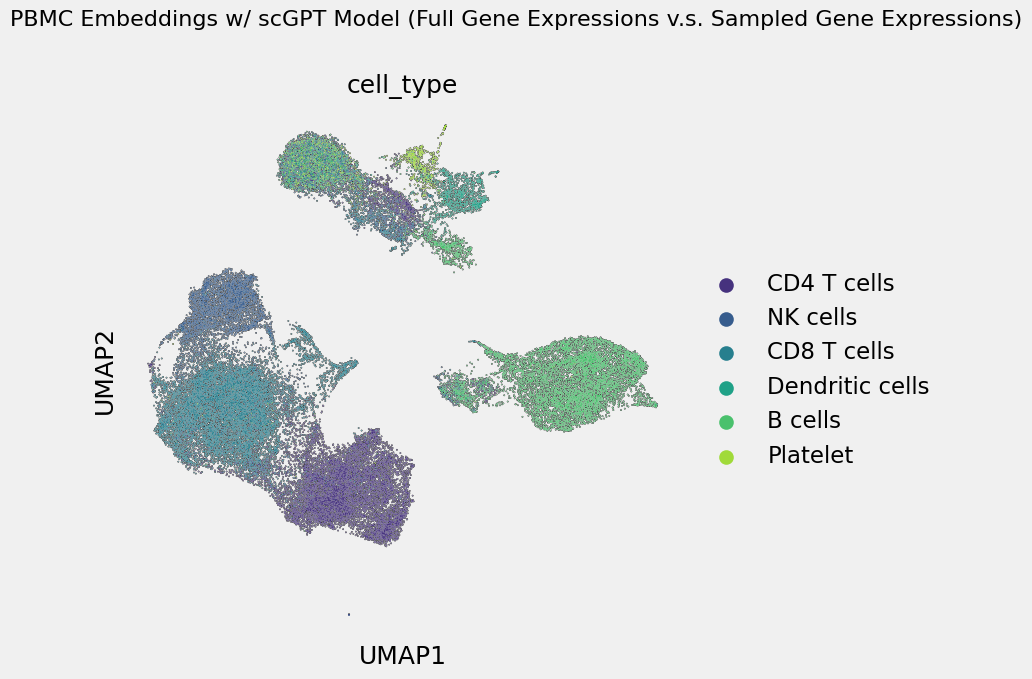

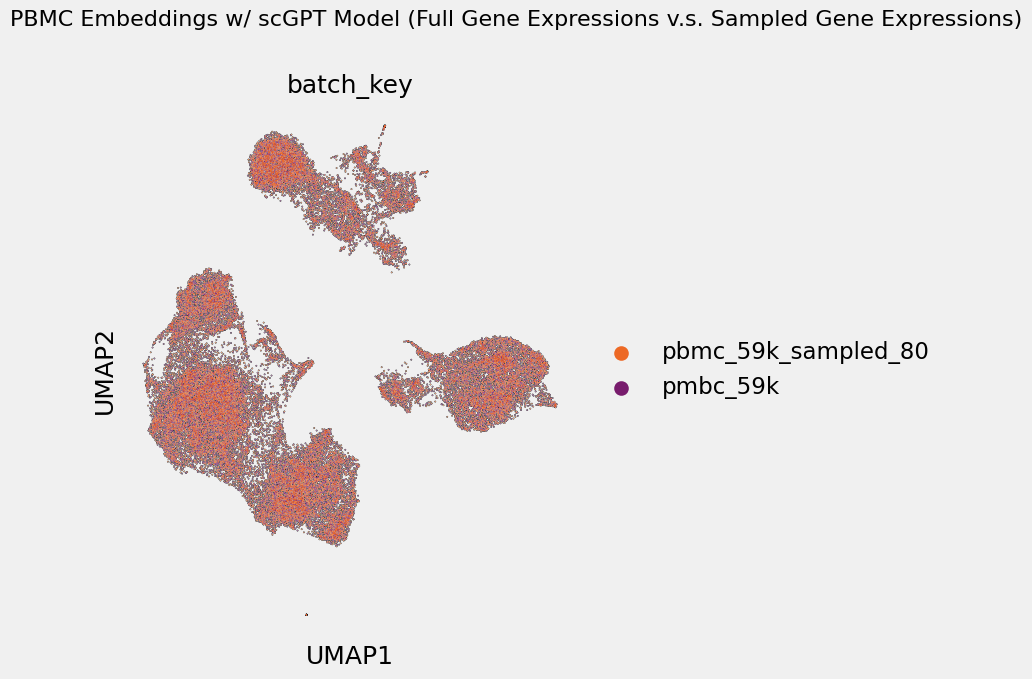

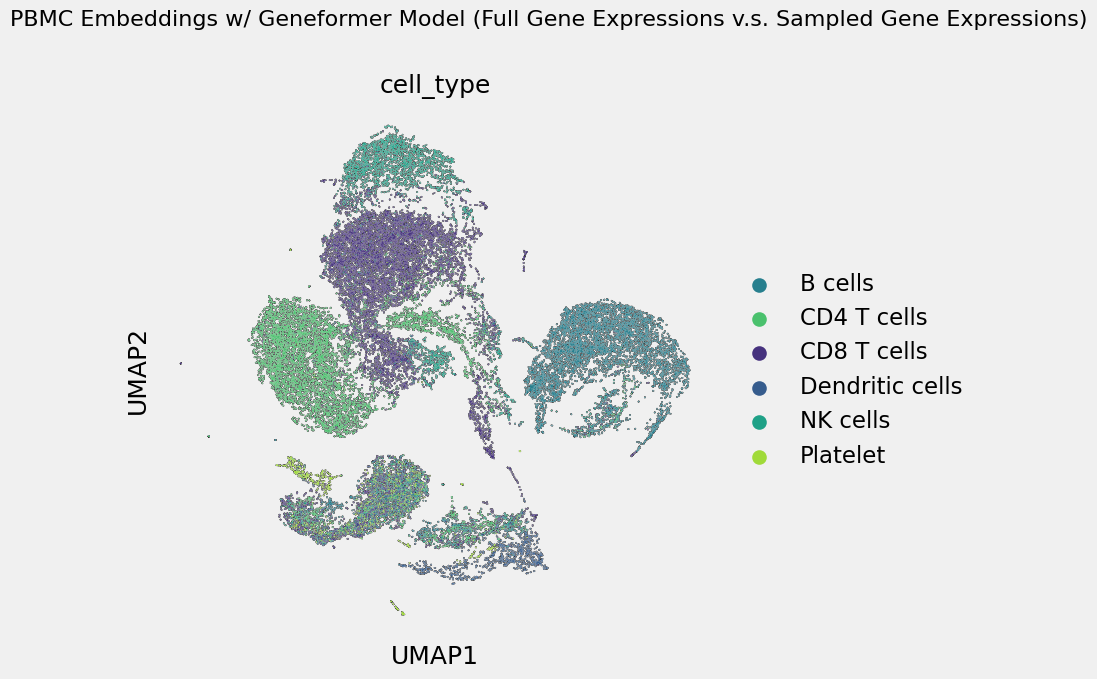

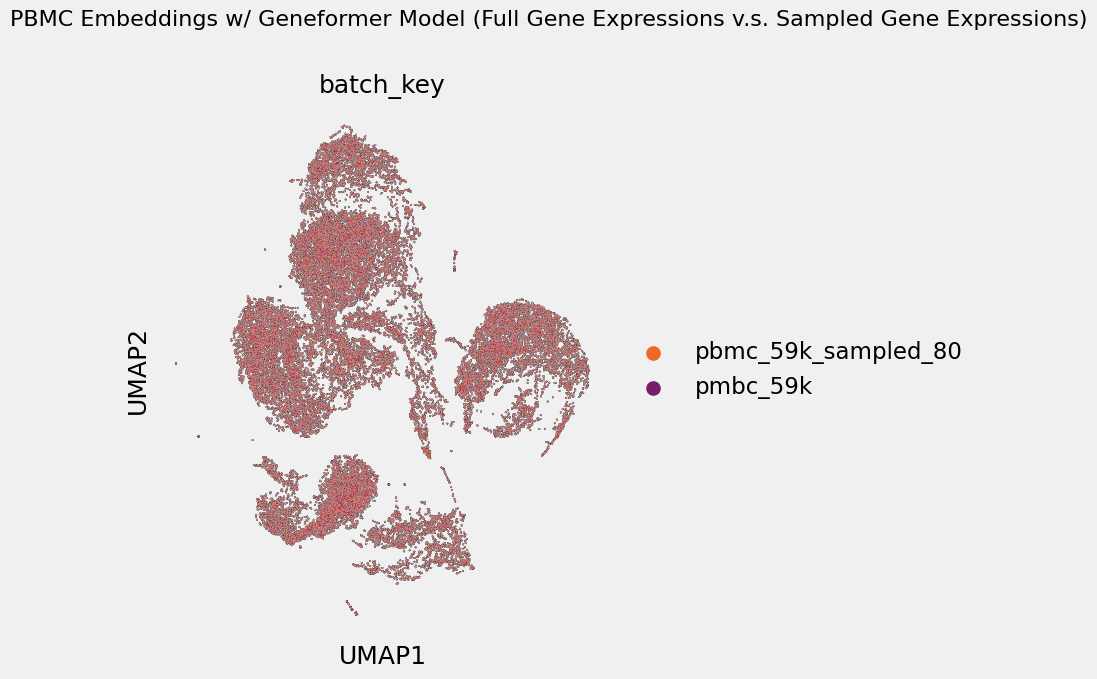

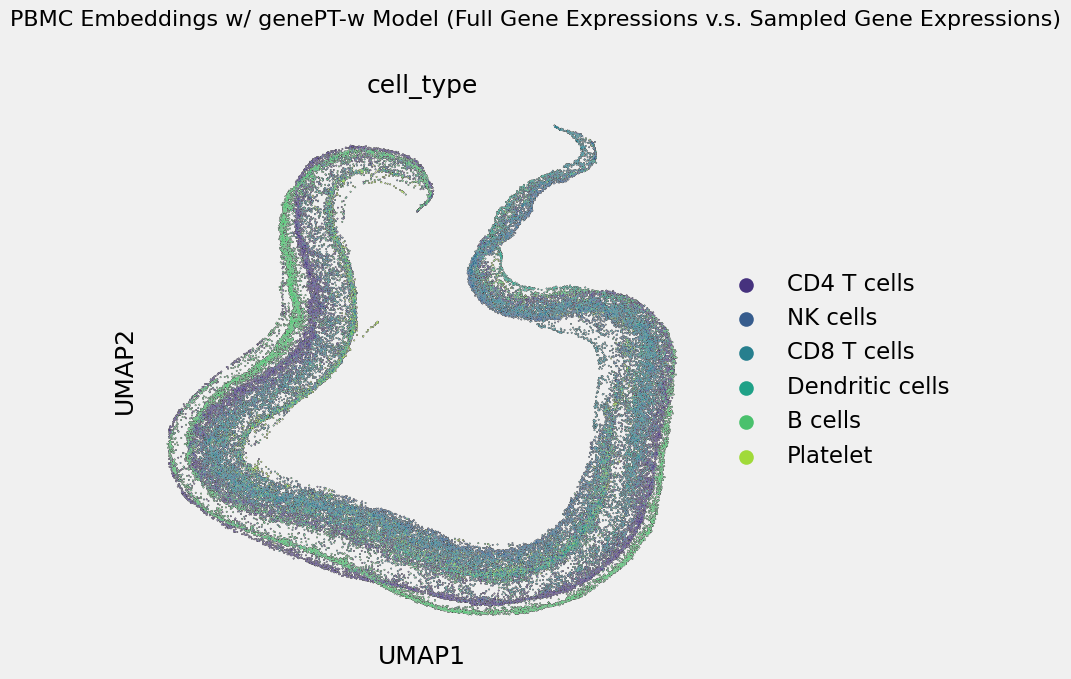

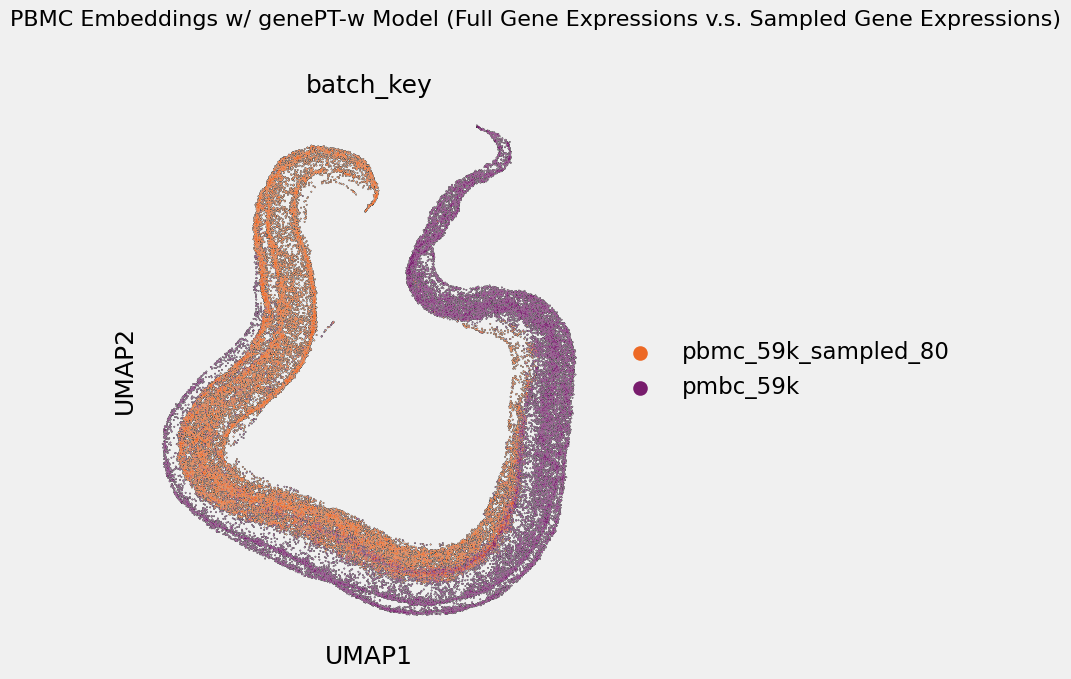

In [7]:
from eval import ZeroShotCellEmbeddingsEval
import warnings

warnings.filterwarnings("ignore")

# Compare cell clusters with gene expressions and sampled gene expressions for pbmc 59k dataset.
for model in {"scGPT", "genePT-w", "Geneformer"}:
    eval = ZeroShotCellEmbeddingsEval(model_name=model,
                                      embedding_file_path=f'pbmc_sampled_n_full/sampled_{model.lower().replace("-", "_")}_cell_embeddings.h5ad',
                                      output_dir=f'pbmc_sampled_n_full/eval/',
                                      embedding_key=f"X_{model}",
                                      label_key=['cell_type'],
                                      label_key_filter=[['B cells', 'Dendritic cells', 'CD4 T cells', 'CD8 T cells',
                                                         'CD14+ Monocytes', 'Platelet', 'NK cells']],
                                      batch_key='batch_key')
    eval.visualize(return_fig=False,
                   plot_title=f"PBMC Embeddings w/ {model} Model (Full Gene Expressions v.s. Sampled Gene Expressions)",
                   plot_type='scanpy',
                   n_cells=-1)

In [8]:
from eval import ZeroShotCellEmbeddingsEval
import warnings

warnings.filterwarnings("ignore")

# Compare cell clusters with gene expressions and sampled gene expressions.
for model in {"scGPT", "genePT-w", "Geneformer"}:
    eval = ZeroShotCellEmbeddingsEval(model_name=model,
                                      embedding_file_path=f'pbmc_sampled_n_full/sampled_{model.lower().replace("-", "_")}_cell_embeddings.h5ad',
                                      output_dir=f'pbmc_sampled_n_full/eval/',
                                      embedding_key=f"X_{model}",
                                      label_key=['cell_type'],
                                      label_key_filter=[['B cells', 'Dendritic cells', 'CD4 T cells', 'CD8 T cells',
                                                         'CD14+ Monocytes', 'Platelet', 'NK cells']],
                                      batch_key='batch_key')
    print(eval.evaluate(n_cells=7500))
    print('\n')

Evaluating scGPT model: 53616 out of 119012 cell embeddings after filtering.
adata_ has 53616 cells. Taking a subset of 7500 cells.
              metric      label     value
0  NMI_cluster/label  cell_type  0.612299
1  ARI_cluster/label  cell_type  0.601297
2          ASW_label  cell_type  0.566181
3         graph_conn  cell_type  0.979672
4          ASW_batch  cell_type  0.500026
5    ASW_label/batch  cell_type  0.979357
6          PCR_batch  cell_type  0.000183
7            avg_bio  cell_type  0.593259


Evaluating Geneformer model: 53616 out of 119012 cell embeddings after filtering.
adata_ has 53616 cells. Taking a subset of 7500 cells.
              metric      label     value
0  NMI_cluster/label  cell_type  0.560307
1  ARI_cluster/label  cell_type  0.576648
2          ASW_label  cell_type  0.534086
3         graph_conn  cell_type  0.975125
4          ASW_batch  cell_type  0.499980
5    ASW_label/batch  cell_type  0.988844
6          PCR_batch  cell_type  0.000121
7            av